In [80]:
# Import required libraries for data analysis and visualization
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

In [81]:
# Configure visualization style and suppress warnings
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Download fraud detection dataset from Kaggle
data_path = kagglehub.dataset_download("amanalisiddiqui/fraud-detection-dataset")
data_file_name = os.listdir(data_path)[0]

# Load the dataset into a pandas DataFrame
df = pd.read_csv(os.path.join(data_path, data_file_name))

In [82]:
# Display the first 5 rows to understand the data structure
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [83]:
# Get detailed information about the dataset (data types, memory usage, non-null counts)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [84]:
# Display all column names in the dataset
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [85]:
# Check the distribution of fraudulent vs non-fraudulent transactions
# Shows class imbalance in the target variable
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [86]:
# Check how many transactions were flagged as fraudulent by the system
df["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [87]:
# Check for missing values in the entire dataset
df.isnull().sum().sum()

np.int64(0)

In [88]:
# Get the dimensions of the dataset (rows, columns)
df.shape

(6362620, 11)

In [89]:
# Calculate the percentage of fraudulent transactions in the dataset
# Result shows fraud is only 0.13% of all transactions - highly imbalanced
round((df["isFraud"].value_counts()[1] / df.shape[0]) * 100, 2)

np.float64(0.13)

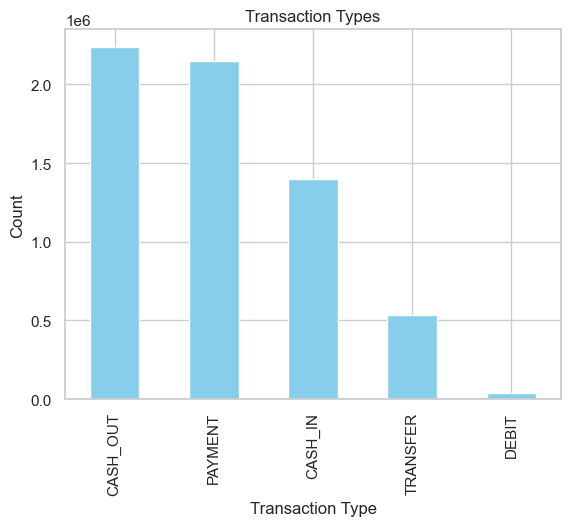

In [90]:
# Visualize the distribution of different transaction types (PAYMENT, TRANSFER, CASH_OUT, etc.)
df["type"].value_counts().plot(kind="bar", title="Transaction Types", color="skyblue")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

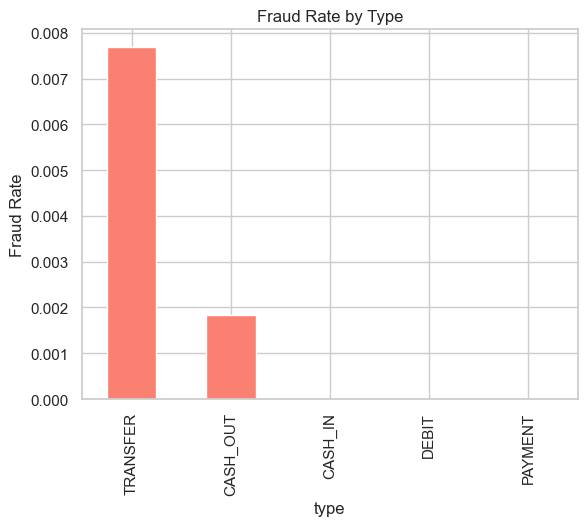

In [91]:
# Calculate and visualize the fraud rate for each transaction type
# This helps identify which transaction types are most susceptible to fraud
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar", title="Fraud Rate by Type", color="salmon")
plt.ylabel("Fraud Rate")
plt.show()

In [92]:
# Get statistical summary of transaction amounts (mean, std, min, max, quartiles)
df["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

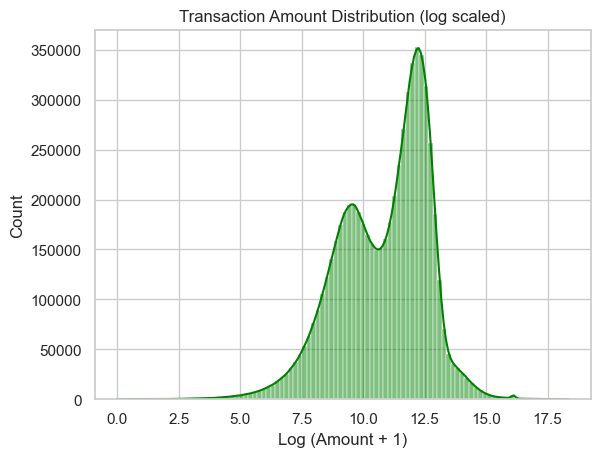

In [93]:
# Visualize transaction amount distribution using log scale
# Log transformation helps visualize skewed data with extreme values
sns.histplot(np.log1p(df["amount"]), bins=100, kde=True, color="green")
plt.title("Transaction Amount Distribution (log scaled)")
plt.xlabel("Log (Amount + 1)")
plt.show()

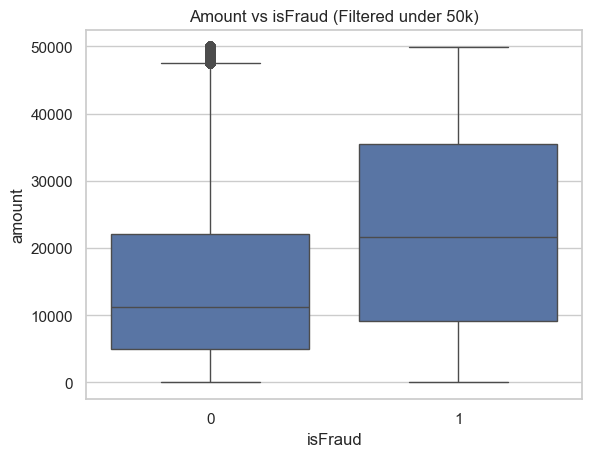

In [94]:
# Compare transaction amounts between fraudulent and non-fraudulent transactions
# Filtered to amounts under 50k for better visualization (removes outliers)
sns.boxplot(data=df[df["amount"] < 50_000], x="isFraud", y="amount")
plt.title("Amount vs isFraud (Filtered under 50k)")
plt.show()

In [95]:
# Create new features: balance differences for origin and destination accounts
# balanceDiffOrig: how much the sender's balance changed (should match transaction amount)
# balanceDiffDest: how much the receiver's balance changed
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

In [96]:
# Check for anomalies: negative balance differences in origin account
# Negative values indicate sender's balance increased, which is suspicious
(df["balanceDiffOrig"] < 0).sum()

np.int64(1399253)

In [97]:
# Check for anomalies: negative balance differences in destination account
# Negative values indicate receiver's balance decreased, which is suspicious
(df["balanceDiffDest"] < 0).sum()

np.int64(1238864)

In [98]:
# Display first 2 rows with the newly created balance difference features
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0


In [ ]:
# Analyze fraud distribution over time (by step/time period)
# Helps identify if fraud occurs more frequently at certain times
frauds_per_step = df[df["isFraud"] == 1]["step"].value_counts().sort_index()
plt.plot(frauds_per_step.index, frauds_per_step.values, label="Frauds per Step")
plt.xlabel("Step (Time)")
plt.ylabel("Number of Frauds")
plt.title("Frauds Over Time")
plt.grid(True)
plt.show()

In [ ]:
# Remove the 'step' column as it's not needed for the model
# Time-based features may not generalize well for fraud prediction
df.drop(columns="step", inplace=True)

In [ ]:
# Verify the dataset after dropping the 'step' column
df.head()